Plano de hoje
-------------

1. Ambiente de programação
2. Usando o computador para calcular    
3. Usando o computador para desenhar
4. Usando o computador para integrar: quadraturas
5. Usando o computador para aproximar: interpolação
    1. Interpolação local
    2. Interpolação de Lagrange
    3. Fenômeno de Runge e pontos de Chebyshev

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Interpolação e extrapolação

A principal razão para interpolar uma função é que esta pode ser "desconhecida".
Isso pode se apresentar em vários níveis:

1. A função que queremos representar só pode ser conhecida experimentalmente
    - Pressão do ar a uma certa altitude (p em função de h)
    - Concentração de sódio na água do mar (c em função de $x,y,z$)
    - Cotação do dólar (\$ em função de t)
    - ...
2. A função talvez tenha uma definição, mas esta pode ser muito complicada de obter
    - "Problemas inversos": $f(x) = y$ onde $x^2 y + \exp(y/x) = 39$
    - "Problemas aritméticos": $f(x) = \text{soma dos divisores de $x$}$.
    - ...
3. Uma combinação dos fenômenos acima

Assim, uma vez que tenhamos dados "suficientes", vamos querer usá-los para ter uma idéia do comportamento global de $f$.
Por exemplo, imagine que saibamos que:

    x    = 0 1 2 5 10
    f(x) = 2 3 3 5 7
Será que podemos prever como será $f(4)$? Isso é o que chamamos de um problema de **interpolação**.
Será que podemos prever como será $f(12)$? Isso é um problema de **extrapolação**.

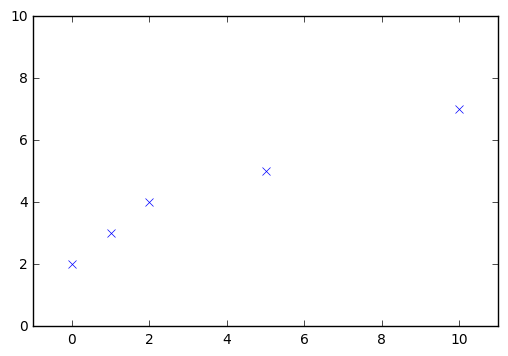

In [2]:
x = [0,1,2,5,10]
y = [2,3,4,5,7]
plot(x,y, 'x')
xlim([-1,11])
ylim([0,10]);

# Interpolação local

A solução **mais simples**, mas muitas vezes suficiente, é, simplesmente, "ligar os pontos com retas".
Se você pensar, o plot faz _exatamente_ isso!

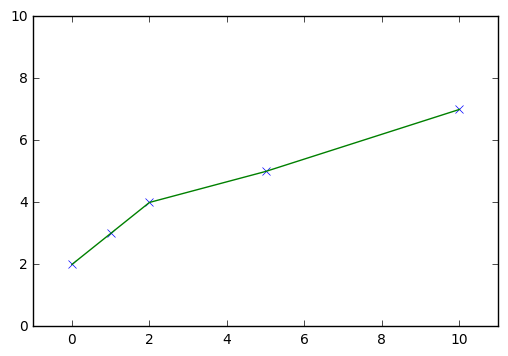

In [3]:
plot(x,y, 'x')
plot(x,y)
xlim([-1,11])
ylim([0,10]);

Este método tem um nome pomposo, se você quiser parecer erudito: _interpolação linear por partes_.
Vejamos porquê:

1. _interpolação_, porque calcula valores "razoáveis" (num certo sentido) para a função apenas "dentro" do intervalo de seus pontos conhecidos
2. _linear_, porque usa uma reta (linha!) para obter os tais valores
3. _por partes_, porque usa uma reta diferente em cada intervalo.

Lembrando dos nossos métodos integrais, podemos renomeá-los!

### Exercício:
Em que categoria se enquadram os métodos de Cauchy, do ponto médio, trapezoidal?
E os dois métodos de ordem 4 (Simpson e Gauss-Legendre)?

## Aumentando a ordem de interpolação

Ao contrário dos métodos que usamos para integrais, e como já vimos no exemplo, nem sempre possuímos pontos igualmente espaçados onde vamos interpolar.
Mas isso não nos impedirá de interpolar a função, apenas teremos que tomar "mais pontos".

### Exercício

Interpole por polinômios de grau 2 os dados acima. Para isso:

1. Note que um polinômio de grau 2 fica determinado quando temos três pontos de abscissas distintas;
2. Escolha 3 pontos $(x, f(x))$;
3. Note que cada ponto $(x, f(x))$ dá uma equação $f(x) = P_2(x) = ax^2 + bx + c$;
4. Determine os coeficientes $a$, $b$ e $c$ resolvendo o sistema linear em $a$, $b$ e $c$;

In [4]:
def lagrange2(x,y):
    """ Finds the 2nd order Lagrange polynomial interpolating data  x  and  y = f(x) """
    # Calcule A,B,C
    A = y[0]/((x[1]-x[0])*(x[2]-x[0])) + y[1]/((x[1]-x[0])*(x[1]-x[2])) + y[2]/((x[2]-x[0])*(x[2]-x[1]))
    B = (y[1]-y[0])/(x[1]-x[0]) - A*(x[1]+x[0])
    C = y[0] - A*x[0]**2 - B*x[0]
    mx = 0
    def interp_f(z):
        return A*(z-mx)**2 + B*(z-mx) + C
    return interp_f

Verifique que o seu polinômio realmente passa pelos 3 pontos.

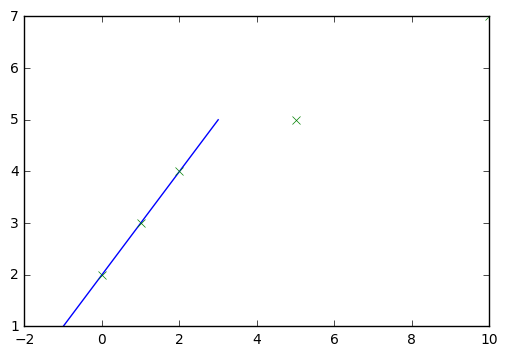

In [5]:
f1 = lagrange2(x[:3], y[:3])
t = linspace(-1,3,100)
plot(t, f1(t))
plot(x,y, 'x');

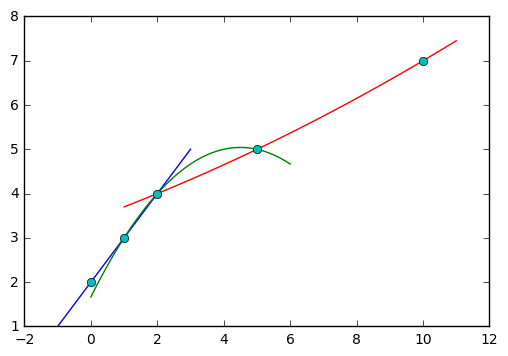

In [6]:
for i in range(len(x) - 2):
    f1 = lagrange2(x[i:i+3], y[i:i+3])
    t = linspace(x[i]-1,x[i+2]+1,100)
    plot(t, f1(t))
plot(x,y, 'o');

Vemos, assim, que usar interpoladores de maior grau pode ser melhor
(quem sabe capturamos melhor o comportamento da função)
mas traz também o problema de **qual** interpolante escolher para um mesmo intervalo.

Voltaremos a este problema com splines, mais à frente.

# Interpolação global

Uma outra idéia é usar **todas** informações simultaneamente.
Assim, podemos usar uma parte para corrigir outra.

## O polinômio interpolador de Lagrange

A idéia fundamental do PIL é que, dados $n+1$ pontos conhecidos,
existe apenas um polinômio de grau $n$ que passa por eles.
Este será o "melhor" polinômio de grau menor ou igual a $n$ que interpola estes dados,
e não faz muito sentido tentar achar polinômios de mais alto grau,
porque existem infinitos que vão passar pelos mesmos pontos!

Assim, temos que descobrir $n+1$ coeficientes - digamos $a_0, a_1, \ldots, a_n$ -
para o nosso polinômio, em função de $n+1$ pontos $x$ e $y$.

## Uma digressão: o método de Horner para calcular polinômios

Um polinômio é definido por seus $n+1$ coeficientes.
Imagine que você queira fazer uma função que calcula $P(x)$ dado um vetor de coeficientes.
Uma forma é usar a definição:
$$ P(x) = \sum _ {k=0}^n a_k x^k $$
que se traduz diretamente em código.
Mas este método faz "contas demais".
Note que ele faz $n$ multiplicações (para cada termo, menos o $i=0$), $n$ adições,
e ainda tem que calcular as potências de $x$.

A idéia é fazer as contas "ao contrário", pensando no polinômio da seguinte forma:
$$ P(x) = a_0 + xQ(x) = a_0 + x(a_1 + xR(x)) = \ldots = a_0 + x(a_1 + x(a_2 + x(\cdots + x\big(a _ {n-1} + x(a_n)\big) \cdots) )), $$
e operar "de dentro para fora dos parêntesis".
Este procedimento é conhecido como _método de Horner_ para polinômios.

In [7]:
def Horner(rcoeff):
    """ Método de Horner. Dados os coeficientes em ordem [a_n, ... a_1, a_0],
        retorna uma função que calcula o polinômio correspondente. """
    def p(x):
        # Inicialização
        acc = rcoeff[0]
        for c in rcoeff[1:]:
            acc *= x
            acc += c
        return acc
    return p

In [8]:
def lagrange(x,y):
    """ Calcula o polinômio interpolador de Lagrange dos pontos $(x_i, y_i)$. """
    assert(len(x) == len(y))
    n = len(x) - 1
    maxx = max(x)
    minx = min(x)
    medx = (maxx + minx)/2
    diffs = array(x) - medx
    M = [ones_like(x)]
    for i in range(n):
        M.append(M[-1]*diffs)
    M = array(M).T
    a = solve(M,y)
    
    def p(z):
        return (Horner(a[::-1]))(z - medx)
    return p

In [9]:
p_i_l = lagrange(x,y)

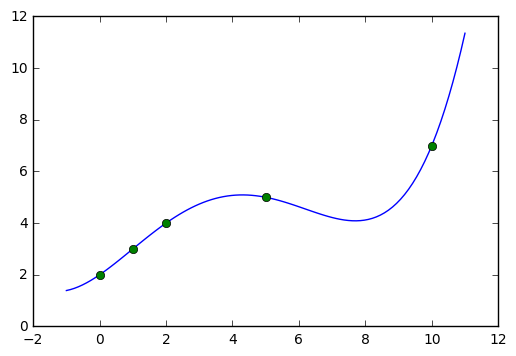

In [10]:
t = linspace(-1,11,100)
plot(t,p_i_l(t))
plot(x,y,'o');

O que vemos aqui é um fenômeno estranho:
apesar de os dados serem crescentes, o interpolador não é crescente!

Este é um dos problemas que atingem a interpolação de Lagrange.
Veremos porquê.

## Análise da interpolação de Lagrange

Apesar de termos formulado o problema de interpolação de Lagrange como a solução de um sistema linear,
é possível expressar a solução de outras formas.

### Polinômios especiais

Como estamos trabalhando com polinômios de grau 4 (porque temos 5 pontos),
o maior número de zeros que um tal polinômio pode ter é 4.
Aliás, é exatamente isso que garante que a solução é _única_.

Vejamos que, dados 5 pontos, existem polinômios de grau 4 que sejam "mais especiais" do que outros.
Especial também pode ser "simples", e por isso vamos tentar achar polinômios "mais simples".
Uma idéia nessa direção é a seguinte: para cada um dos pontos $x_i$,
existe um único polinômio $P_i$ que vale $1$ neste ponto, e $0$ nos outros 4.
Como ele vale zero em 4 pontos e tem grau 4, ele tem que ser da forma
$$ P_i(x) = C_i \prod_{j \neq i} (x - x_j), $$
onde $C_i$ é uma constante.
Ora, se $P_i(x_i) = 1$, isso dá uma equação para $C_i$:
$$ 1 = C_i \prod_{j \neq i} (x_i - x_j). $$
Assim, temos:
$$ P_i = \prod_{j \neq i} \frac{x - x_j}{x_i - x_j}.$$

Agora, note que se uma função $f$ vale $y_0 \neq 0$ em $x_0$
a _única_ forma de, usando os $P_i$, obter este valor será usando $y_0 \times P_i(x)$.

### Exercício

Deduza a fórmula do polinômio interpolador de Lagrange de $f$ nos $x_i$:
$$ I_f(x) = \sum_{i = 0}^n \left[ y_i \prod_{j \neq i} \frac{x - x_j}{x_i - x_j} \right]. $$
Plote os 5 polinômios $P_i$ para os pontos $x = [0,1,2,5,10]$.

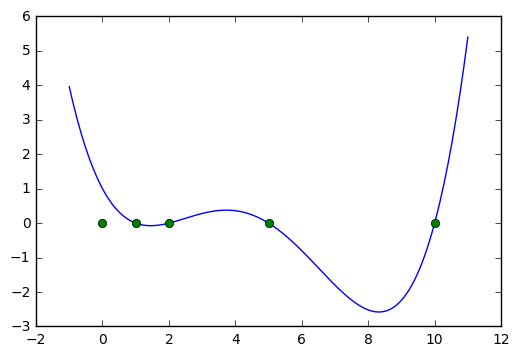

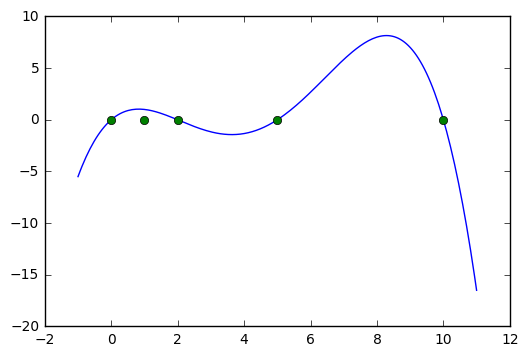

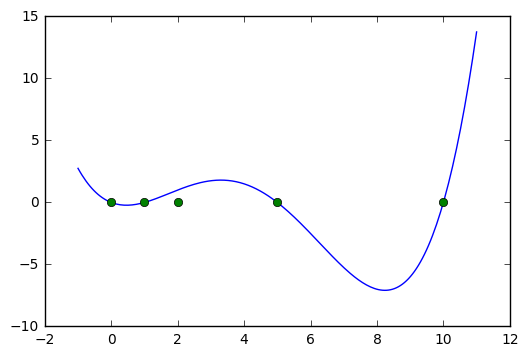

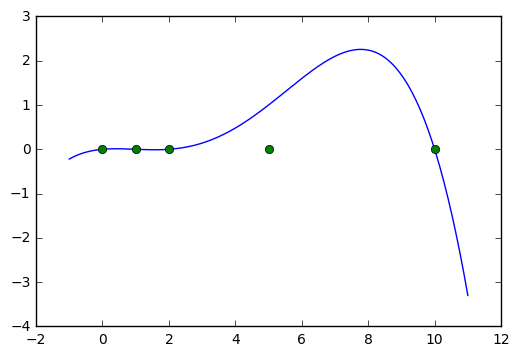

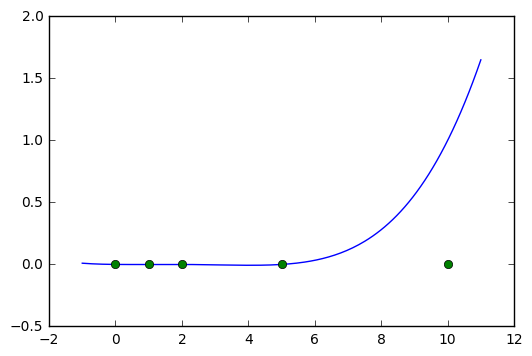

In [11]:
from functools import reduce
produto = lambda y,z : y*z

def l_k (k,X):
    def p(x):
        return reduce(produto, [(x-x_j)/(X[k]-x_j) for j,x_j in enumerate(X) if j != k], 1)
    return p

Pis = [l_k(k,x) for k in range(len(x))]

t = linspace(-1,11,200)
for P in Pis:
    figure()
    plot(t, P(t))
    plot(x, zeros_like(x), 'o')

# Fenômeno de Runge

Vimos que os polinômios especiais -
os que se anulam em todos os pontos de interpolação exceto um deles -
são oscilatórios, e isso causa erros de aproximação.
Veremos aqui um exemplo onde estes erros ficam cada vez maiores conforme
o número de pontos de interpolação aumenta!

In [12]:
def f(x): return 1/(1 + x**2)

Vamos interpolar $\frac{1}{1 + x^2}$ em intervalos diferentes:

In [13]:
def varios_lagrange(f,a,b,ns):
    maxn = max(ns)
    ts = linspace(a,b,30*maxn)
    figure(figsize=(18,5))
    subplot(1,3,1)
    plot(ts, f(ts))

    for n in ns:
        xs = linspace(a,b,n)
        ys = f(xs)
        p_i_l = lagrange(xs,ys)
        subplot(1,3,1)
        plot(ts, p_i_l(ts), label='ordem {}'.format(n))
        subplot(1,3,2)
        plot(ts, p_i_l(ts) - f(ts), label='ordem {}'.format(n))
        subplot(1,3,3)
        semilogy(ts, abs(p_i_l(ts) - f(ts)), label='ordem {}'.format(n))
    for i in range(3):
        subplot(1,3,i+1)
        legend(loc=0);

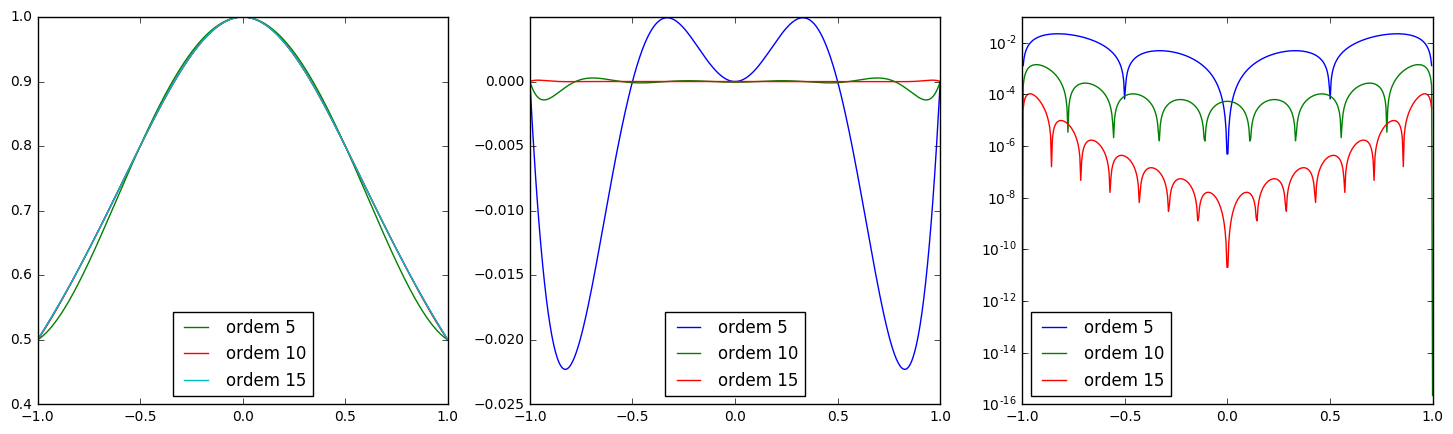

In [14]:
varios_lagrange(f,-1,1,[5,10,15])

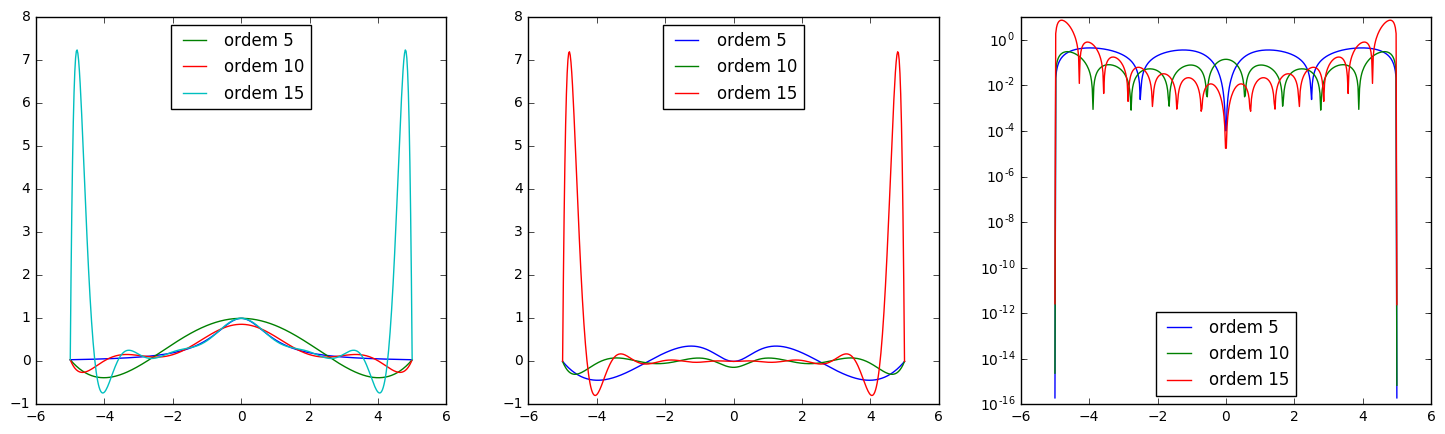

In [15]:
varios_lagrange(f,-5,5,[5,10,15])

Veja que este erro "nos cantos" não aparece se o intervalo for _apenas_ $[-5,-1]$:

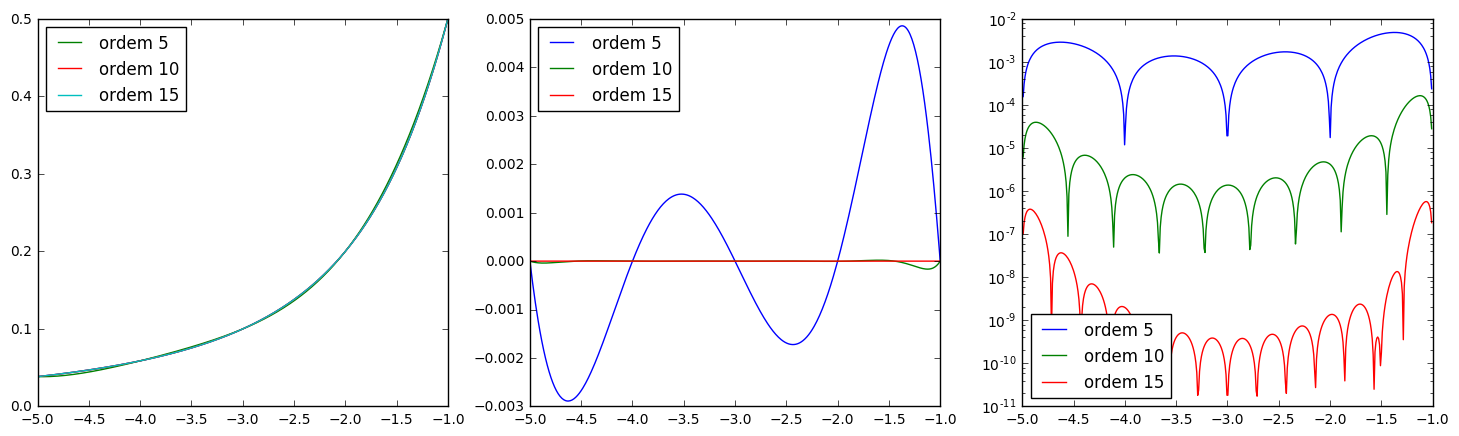

In [16]:
varios_lagrange(f,-5,-1,[5,10,15])

## Análise

Se $f$ é uma função com $n+1$ derivadas,
podemos estimar o erro cometido pelo polinômio interpolador de grau $n$ através da fórmula:
$$ P_n(x) - f(x) = \frac{f^{(n+1)}(\xi)}{(n+1)!} \prod_{i = 0}^n (x - x_i) $$
onde, como de hábito, $\xi$ é um ponto do intervalo $[a,b]$ que depende de $x$.

Se quisermos estimar o erro, precisamos entender o comportamento de duas componentes:

- a $(n+1)$-ésima derivada de $f$
- o fator $\omega_n(x) = \prod_{i = 0}^n (x - x_i)$, conhecido como *polinômio nodal*.

Comecemos por $\omega$.

### Exercício:

Calcule os polinômios nodais para 5 e 15 nós no intervalo $[-5,5]$, e compare suas magnitudes.

In [19]:
def nodal(x):
    def f(z):
        ndl = 1
        for x_i in x:
            ndl *= (z - x_i)
        return ndl
    return f

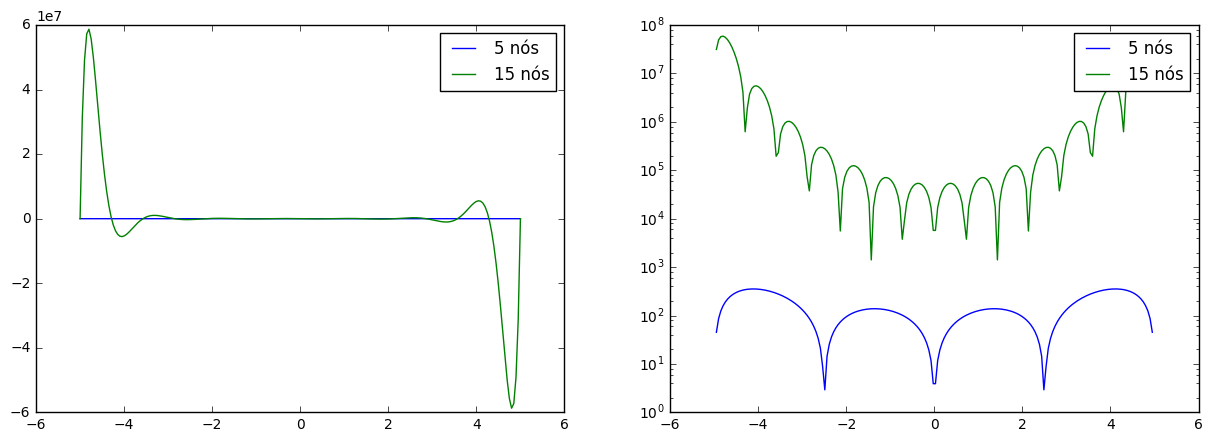

In [20]:
p5 = nodal(linspace(-5,5,5))
p15 = nodal(linspace(-5,5,15))
t = linspace(-5,5,200)
figure(figsize=(15,5))
subplot(1,2,1)
plot(t, p5(t), label='5 nós')
plot(t, p15(t), label='15 nós')
legend()
subplot(1,2,2)
semilogy(t, abs(p5(t)), label='5 nós')
semilogy(t, abs(p15(t)), label='15 nós')
legend();

### Exercício

Mostre que, se dividirmos o intervalo $[0,1]$ em $n$ partes iguais, e se $x \in (0,1)$, então
$$ \omega_n(x) \leq \frac{n!}{4 n^{n+1}}. $$

Dica: Vimos experimentalmente que os máximos estão perto dos extremos, então comece supondo que $x \in (0, 1/n)$.

Deduza o que acontece num intervalo $[a,b]$ qualquer.

## Limitando

Assim, vemos que o erro de aproximação usando interpolação de Lagrange com pontos igualmente espaçados será, no máximo:
$$ \frac{f^{(n+1)}}{(n+1)!} \frac{n!}{4 n^{n+1}} = \frac{f^{(n+1)}}{n+1} \frac{1}{4 n^{n+1}}. $$
Portanto, conforme $n$ cresce, temos que compensar a derivada $(n+1)$-ésima
com um fator que é cada vez "melhor" $n^{n+1}$ no denominador.
Infelizmente, para algumas funções, a derivada cresce bem mais rápido do que este fator,
e isso causa os erros que vimos.

# Estabilidade

Uma característica bastante desejável de métodos de interpolação é que estes sejam robustos.
Por exemplo, imagine que estamos usando interpolação para analisar o comportamento de uma função
a partir de dados experimentais.
É claro que estes dados contém erros, e portanto nossa interpolação, também.
Porém, seria extremamente nocivo se os erros da interpolação fossem _muito_ maiores do que os erros iniciais:
o método seria praticamente inútil!

Diremos que um método (algoritmo) é _estável_ quando os erros de saída sejam comparáveis aos dos dados fornecidos.

### Exercício

Analise a robustez dos métodos de derivada discreta em função de $h$.

## Análise de estabilidade

Se temos uma função $f$ que produz os valores $y_i$ dados os pontos $x_i$,
e que há erros de medição e usamos valores perturbados $z_i = (y_i + \varepsilon_i)$,
a diferença entre os polinômios interpoladores $P$ (correto) e $Q$ (com erros) será:
$$ P(x) - Q(x) = \sum_{i = 0}^n y_i \phi_i(x) - \sum_{i = 0}^n z_i \phi_i(x)
  = \sum_{i = 0}^n \varepsilon_i \phi_i(x).$$
Tomando valores absolutos e usando a desigualdade triangular:
$$ \lvert P(x) - Q(x) \rvert \leq \big(\max_i |\varepsilon_i|\big) \sum_{i = 0}^n \lvert \phi_i(x) \rvert.$$

Assim, o "fator de distorção" será, no máximo,
$$\sum_{i = 0}^n \lvert \phi_i(x) \rvert,$$
que só depende dos pontos $x_i$ usados para interpolação.

In [ ]:
x = linspace(0,1,10)
Pis = lagrange_basis(x)

In [ ]:
t = linspace(0,1,200)
plot(t, sum([abs(P(t)) for P in Pis], axis=0))
plot(x, zeros_like(x), 'o');

Tomando $n$ pontos igualmente espaçados, temos infelizmente que o fator de distorção será algo como
$$ \frac{2^n}{n} $$
que tende para infinito quando $n$ aumenta.
Assim, não adianta usar mais pontos para garantir um menor erro.

# Polinômios de Chebyshev

Mas, a priori, nada nos obriga a usar pontos equiespaçados para calcular a função.
Dependendo de como os dados $y_i$ serão obtidos, talvez seja possível usar outros pontos $x_i$,
que produzam um polinômio nodal "menor".
Assim, gostaríamos de resolver o seguinte problema:

Achar pontos $x_0$, $x_1$, $\ldots$, $x_n$ no intervalo $[-1,1]$ de forma a minimizar o polinômio nodal
$$ \prod_{i = 0}^{n+1} (x - x_i). $$

### Exercício:

Resolva o caso $n = 1$.

Queremos minimizar (em $a$ e $b$) o máximo do valor absoluto de $(x-a)(x-b)$ onde $x$ percorre o intervalo $[-1,1]$.
Fixos $a$ e $b$, há três candidatos para o máximo: $x = -1$, $x = 1$, $x = (a+b)/2$.
O valor nestes três pontos é
- $(a+1)(b+1)$
- $(1-a)(1-b)$
- $(b-a)^2/4$

In [ ]:
def nodalmax(a,b):
    return max((a+1)*(b+1), (1-a)*(1-b), (b-a)**2/4,0)

a = linspace(-1,1,100)
b = linspace(-1,1,100)

matshow([[nodalmax(x,y) for x in a] for y in b])
colorbar();

In [ ]:
plot(a, [nodalmax(x,-x) for x in a]);

É possível mostrar que o caso geral tem uma solução bastante simples:
basta escolher os pontos $x_i = \cos\left(\pi\frac{2i + 1}{2(n+1)}\right)$ 

In [ ]:
n = 8
ang = arange(1,2*n+1,2)
x = cos(pi*ang/2/n)
P = nodal(x)

t = linspace(-1,1,200)
plot(t, P(t));

Note que os pontos estão mais espaçados no meio do que nos cantos:
assim, diminuímos o produto $\omega$ para os pontos nesta região,
e aumentamos no resto, mas de forma equilibrada.